# Job Recommendation System
---
### By. [Sinta Siti Nuriah](https://www.linkedin.com/in/sintasitinuriah/)
![job](https://www.northyorks.gov.uk/sites/default/files/2024-04/jobsearchlandingimage.jpg)

# Data Understanding

## a. Data Loading

In [ ]:
!pip install -q kaggle
!pip install lightfm

In [30]:
import re
import ast
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import normalize
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score

from lightfm import LightFM
from lightfm.cross_validation import random_train_test_split
from lightfm.data import Dataset
from lightfm.evaluation import precision_at_k, auc_score, recall_at_k


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!mkdir ~/.kaggle
!cp /content/drive/MyDrive/Colab\ Notebooks/MLT/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
!kaggle datasets download -d lastman0800/job-recomendation-dataset

Dataset URL: https://www.kaggle.com/datasets/lastman0800/job-recomendation-dataset
License(s): unknown
job-recomendation-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!unzip /content/job-recomendation-dataset.zip

Archive:  /content/job-recomendation-dataset.zip
replace Job Datsset.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [2]:
df = pd.read_csv('Job Datsset.csv')

In [3]:
df

,User_ID,Job_ID,User_Skills,Job_Requirements,Match_Score,Recommended
0,1,16,"Python, C++, Machine Learning","SQL, CSS, AI, JavaScript, Data Science",0.620421,0
1,2,30,"AI, Python, Data Science","AI, Data Science, SQL, Python, CSS",0.823451,1
2,3,319,"CSS, Python, Machine Learning","SQL, AI, Python",0.703830,0
3,4,399,"SQL, Machine Learning, C++","Java, AI, Python, Data Science, Machine Learning",0.224724,0
4,5,405,"Machine Learning, HTML, JavaScript","Machine Learning, C++",0.296453,0
...,...,...,...,...,...,...
99995,99996,380,"C++, Machine Learning, SQL","Machine Learning, C++, CSS, SQL, HTML",0.537153,0
99996,99997,402,"C++, SQL, HTML, Python, JavaScript","Data Science, AI, JavaScript",0.319933,0
99997,99998,212,"Data Science, C++","C++, Java",0.292062,0
99998,99999,40,"Python, HTML, AI","AI, CSS, Python, C++, JavaScript",0.450705,0


In [4]:
df.shape

(100000, 6)

Data ini memiliki 100.000 data dengan 6 kolom. kolom-kolom yang dimaksud adalah sebagai berikut; `User_ID`, `Job_ID`, `User_Skills`, `Job_Requirements`, `Match_Score` dan `Recommended`. Data yang dimiliki cukup banyak dan memungkinan untuk membuat job recommendation system lebih optimal.

## b. Deskripsi Variabel
Variabel-variabel pada dataset job rekomendai adalah sebagai berikut:
- `User_ID`: ID unik untuk setiap pengguna dalam dataset.
- `Job_ID`: ID unik untuk setiap pekerjaan yang tercantum dalam dataset.
- `User_Skills`: Daftar keterampilan yang dimiliki oleh pengguna.
- `Job_Requirements`: Daftar keterampilan yang dibutuhkan untuk setiap pekerjaan
- `Match_Score`: Skor kecocokan antara keterampilan pengguna dan kebutuhan pekerjaan. Semakin tinggi, semakin cocok.
- `Recommended`:  Indikator biner: 1 jika pekerjaan direkomendasikan, 0 jika tidak.

### c. Jumlah Data pada Dataset

In [5]:
for i, (nama_kolom, jumlah) in enumerate(df.count().items(), 1):
  print(f'Kolom {i}: {nama_kolom} - Berjumlah: {jumlah}')

Kolom 1: User_ID - Berjumlah: 100000
Kolom 2: Job_ID - Berjumlah: 100000
Kolom 3: User_Skills - Berjumlah: 100000
Kolom 4: Job_Requirements - Berjumlah: 100000
Kolom 5: Match_Score - Berjumlah: 100000
Kolom 6: Recommended - Berjumlah: 100000


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 6 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   User_ID           100000 non-null  int64  
 1   Job_ID            100000 non-null  int64  
 2   User_Skills       100000 non-null  object 
 3   Job_Requirements  100000 non-null  object 
 4   Match_Score       100000 non-null  float64
 5   Recommended       100000 non-null  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 4.6+ MB


Dari hasil diatas terdapat:
- Total tabel yang ada pada dataset tersebut adalah 6 kolom
- tipe data `object` ada 2 kolom yaitu `User_Skills` dan `Job_Requirements`
- tipe data `int64` ada 3 kolom yaitu `User_ID`, `Job_ID`, dan `Recommended`
- tipe data `float64` hanya satu yaitu `Match_Score`

In [7]:
df.describe()

,User_ID,Job_ID,Match_Score,Recommended
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,50000.500000,249.849150,0.499186,0.199270
std,28867.657797,144.536641,0.289118,0.399453
min,1.000000,1.000000,0.000015,0.000000
25%,25000.750000,124.000000,0.249226,0.000000
50%,50000.500000,250.000000,0.498731,0.000000
75%,75000.250000,375.000000,0.750351,0.000000
max,100000.000000,500.000000,0.999993,1.000000


Fungsi describe() memberikan informasi statistik pada masing-masing kolom, antara lain:

* Count adalah jumlah sampel pada data.
* Mean adalah nilai rata-rata.
* Std adalah standar deviasi.
* Min yaitu nilai minimum setiap kolom.
* Max adalah nilai maksimum.
---
Kuartil adalah nilai yang menandai batas interval dalam empat bagian sebaran yang sama.
* 25% adalah kuartil pertama.
* 50% adalah kuartil kedua, atau biasa juga disebut median (nilai tengah).
* 75% adalah kuartil ketiga.

### d. Kondisi Dataset

In [8]:
df.isnull().sum()

User_ID             0
Job_ID              0
User_Skills         0
Job_Requirements    0
Match_Score         0
Recommended         0
dtype: int64

Dataset ini tidak memiliki nilai kosong

In [9]:
df.duplicated().sum()

0

Data ini juga tidak memiliki nilai yang duplikat

In [10]:
# total outlier
Q1 = df.select_dtypes(include=np.number).quantile(0.25)
Q3 = df.select_dtypes(include=np.number).quantile(0.75)
IQR = Q3 - Q1
print(IQR)

User_ID        49999.500000
Job_ID           251.000000
Match_Score        0.501125
Recommended        0.000000
dtype: float64


Dataset ini memiliki otlier pada fitur `User_ID`, `Job_ID`, `Match_Score` dan `Recommended`

### Tanda
Fitur yang dimanfaatkan untuk membangun rekomendasi sederhana adalah `User_ID`, `Job_ID`, `User_Skills`, `Job_Requirements` dan `Recommended`. Dalam pembuatan model dengan menggunakan Content Based Filtering fituer yang digunakan adalah `User_Skills` dan `Job_Recommended`. Sementara itu untuk model menggunakan Collaboratorive Filtering fitur yang digunakan adalah `User_ID`, `Job_ID` dan `Recommended`.

## c. Visualisasi Unvariate - EDA

Visualisasi Kolom menggunakan Boxplot

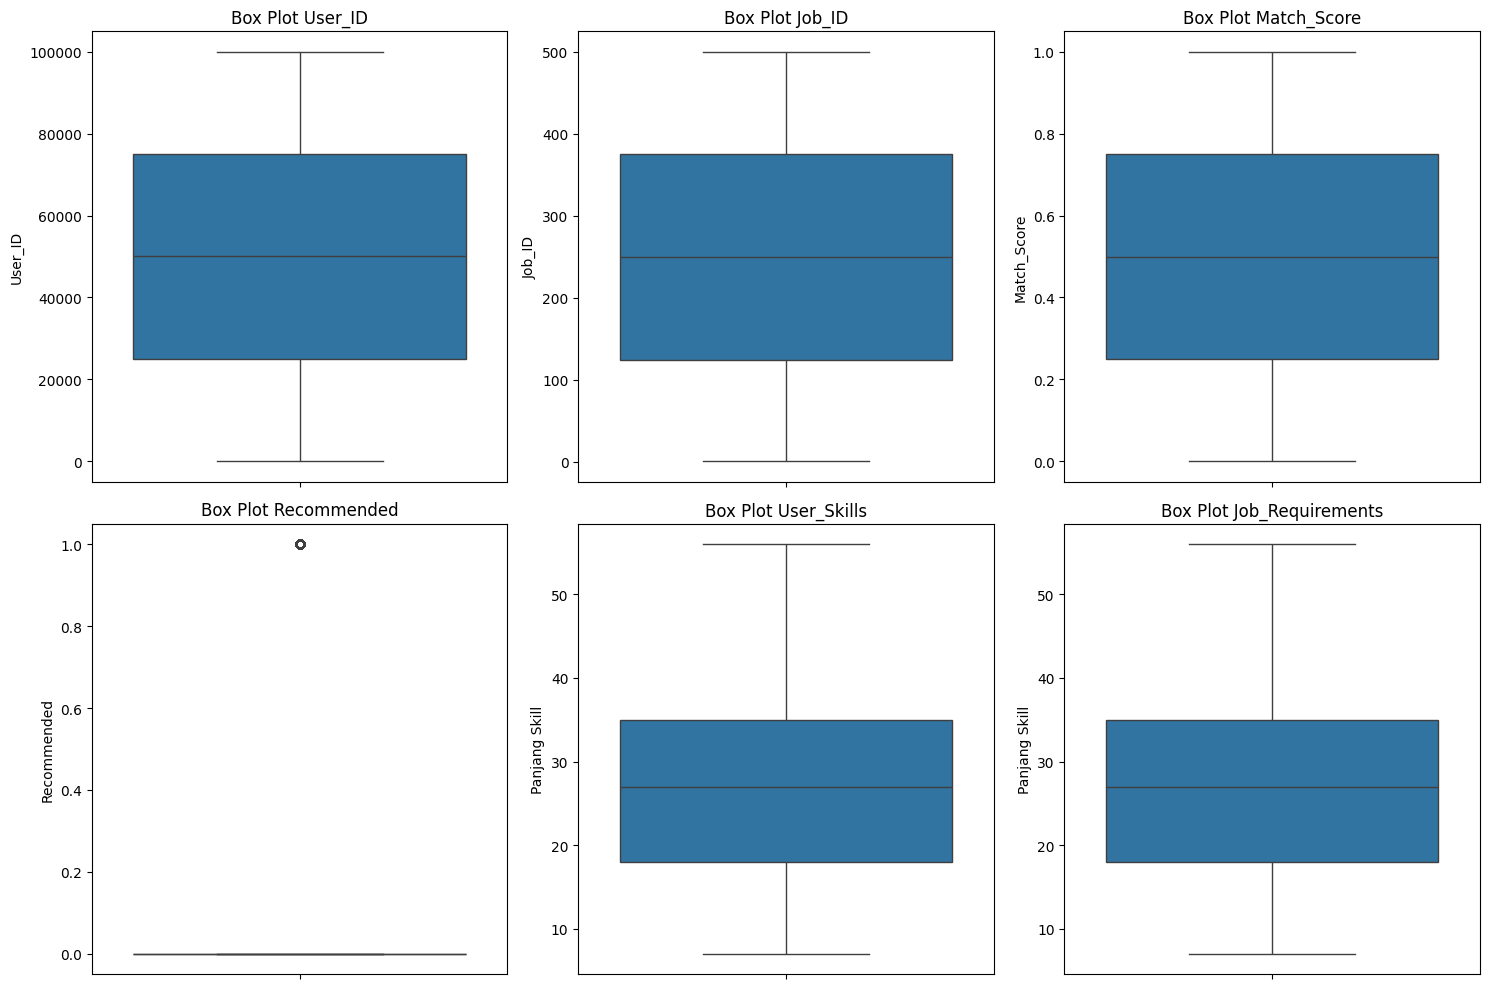

In [11]:
# Tentukan fitur-fitur yang ingin ditampilkan
fitur = ['User_ID', 'Job_ID', 'Match_Score', 'Recommended',
         'User_Skills', 'Job_Requirements']
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

for i, fitur_name in enumerate(fitur):
    row = i // 3
    col = i % 3
    ax = axes[row, col]

    if fitur_name in ['User_Skills', 'Job_Requirements']:

        skill_lengths = df[fitur_name].str.len()
        sns.boxplot(y=skill_lengths, ax=ax)
        ax.set_ylabel('Panjang Skill')
    else:
        sns.boxplot(data=df, y=fitur_name, ax=ax)
        ax.set_ylabel(fitur_name)

    ax.set_title(f'Box Plot {fitur_name}')

plt.tight_layout()
plt.show()

Berikut penjelasan masing-masing box plot:
1. Box Plot User_ID
   - Menampilkan distribusi dari nilai User_ID.
   - Data ini bersifat numerik dan mungkin merupakan ID unik untuk pengguna.
   - Terlihat sebaran ID cukup merata dari 0 hingga sekitar 100.000.

2. Box Plot Job_ID
   - Menampilkan distribusi Job_ID, yang tampaknya juga merupakan ID unik untuk pekerjaan.
   - Sebarannya berkisar dari 0 hingga 500, dengan persebaran data cukup luas.

3. Box Plot Match_Score
   - Menampilkan skor kecocokan antara pengguna dan pekerjaan (nilai antara 0–1).
   - Median sekitar 0.5, menunjukkan bahwa rata-rata kecocokan bersifat sedang.
   - Ada variasi cukup besar, yang berarti skor ini cukup beragam di dataset.

4. Box Plot Recommended
   - Berisi data biner (0 dan 1), menunjukkan apakah pekerjaan direkomendasikan untuk pengguna.
   -nHampir semua data berada di angka 0, hanya sedikit outlier di angka 1.
   -nIni menunjukkan bahwa mayoritas pekerjaan tidak direkomendasikan, hanya sebagian kecil yang direkomendasikan.

5. Box Plot User_Skills
   - Menampilkan jumlah keterampilan yang dimiliki pengguna (dalam satuan panjang daftar keterampilan).
   - Sebaran berkisar dari sekitar 10 hingga 55+.
   - Median di sekitar 25–30 keterampilan.

6. Box Plot Job_Requirements
   - Menampilkan jumlah keterampilan yang dibutuhkan oleh pekerjaan (juga dalam satuan panjang daftar).
   - Distribusinya sangat mirip dengan User_Skills, menunjukkan kemungkinan adanya pencocokan.

Visualisasi Histogram

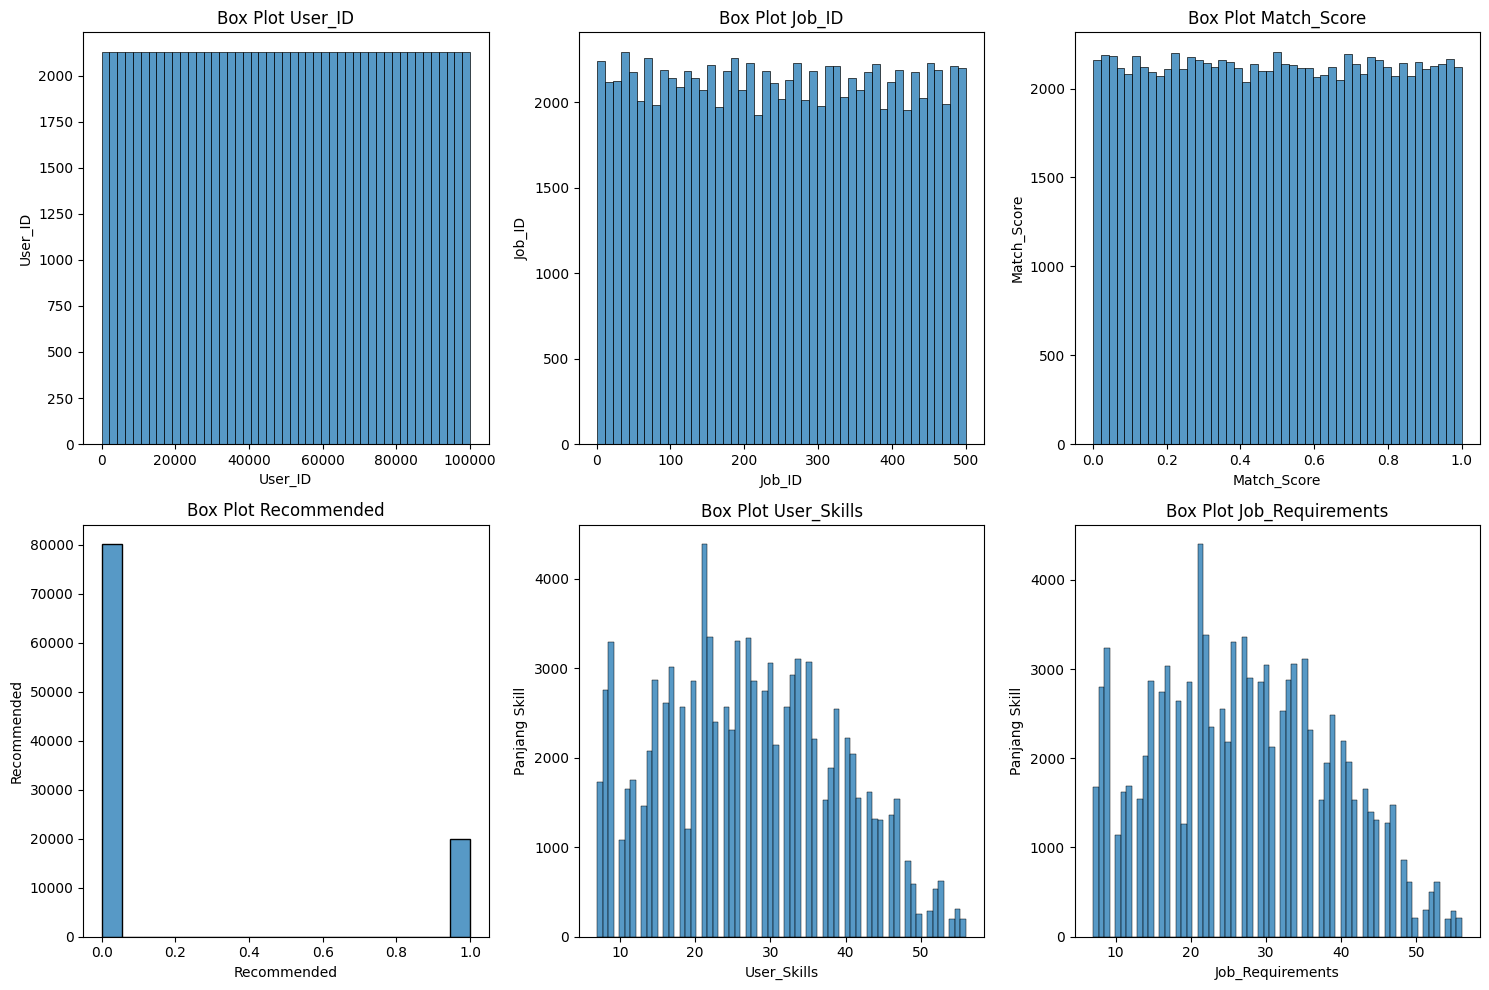

In [12]:
# Tentukan fitur-fitur yang ingin ditampilkan
fitur = ['User_ID', 'Job_ID', 'Match_Score', 'Recommended',
         'User_Skills', 'Job_Requirements']
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

for i, fitur_name in enumerate(fitur):
    row = i // 3
    col = i % 3
    ax = axes[row, col]

    if fitur_name in ['User_Skills', 'Job_Requirements']:

        skill_lengths = df[fitur_name].str.len()
        sns.histplot(x=skill_lengths, ax=ax)
        ax.set_ylabel('Panjang Skill')
    else:
        sns.histplot(data=df, x=fitur_name, ax=ax)
        ax.set_ylabel(fitur_name)

    ax.set_title(f'Box Plot {fitur_name}')

plt.tight_layout()
plt.show()

Berikut penjelasan per subplot:
1. User_ID
   - Histogram menunjukkan distribusi yang rata (uniform), menandakan bahwa ID pengguna tersebar merata dari 0 hingga 100.000.
   - Ini menunjukkan tidak ada dominasi oleh ID tertentu; bisa jadi data ini di-generate secara acak atau seimbang.

2. Job_ID
   - Sama seperti User_ID, distribusinya relatif merata, dari ID 0 hingga 500.
   - Ini juga menunjukkan tidak ada pekerjaan yang secara signifikan lebih banyak muncul dibanding yang lain.

3. Match_Score
   - Distribusinya merata di seluruh rentang 0–1.
   - Artinya, skor kecocokan antara pengguna dan pekerjaan menyebar secara seragam, tidak bias ke skor tinggi atau rendah.

4. Recommended
   - Nilai 0 (tidak direkomendasikan) sangat dominan (~80.000), sementara nilai 1 (direkomendasikan) jauh lebih sedikit (~20.000).
   - Ini mengindikasikan bahwa sebagian besar kombinasi user-job tidak direkomendasikan.
   - Distribusi sangat tidak seimbang (kelas tidak seimbang / imbalanced class).

5. User_Skills
   - Distribusi keterampilan pengguna tampak seperti distribusi normal miring ke kiri (left-skewed).
   - Mayoritas pengguna memiliki 20–35 keterampilan.
   - Ada penurunan tajam setelah jumlah keterampilan >40.

6. Job_Requirements
   - Sangat mirip dengan distribusi User_Skills.
   - Ini menunjukkan bahwa jumlah keterampilan yang diminta oleh pekerjaan juga mayoritas berada di kisaran 20–35.

## c. Visualisasi Multivariate - EDA

Visualisasi Matriks Korelasi

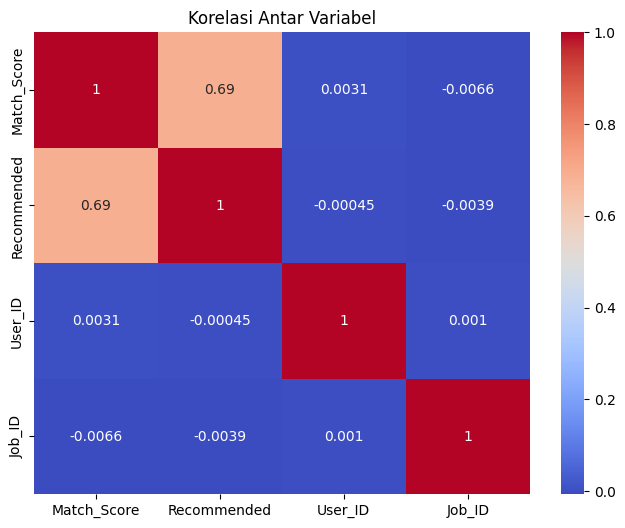

In [13]:
# Pilih kolom numerik yang ingin divisualisasikan
numeric_cols = ['Match_Score', 'Recommended', 'User_ID', 'Job_ID']

# Hitung matriks korelasi
corr_matrix = df[numeric_cols].corr()

# Buat heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Korelasi Antar Variabel')
plt.show()

|Pasangan Varabel|Nilai Korelasi|Interpretasi|
|----------------|--------------|------------|
|Match_Score & Recommended|0.69|Korelasi positif kuat → semakin tinggi match score, semakin besar peluang pekerjaan direkomendasikan.|
|Match_Score & User_ID|0.0031|Korelasi sangat lemah /tidak signifikan|
|Match_Score & Job_ID|-0.0066|Korelasi sangat lemah dan negatif|
|Recommended & User_ID|-0.00045| Kolerasi tidak signifikan|
|Recommended & Job_ID|-0.0039|Korelasi tidak signifikan|
|Recommended & Job_ID|0.001|Hampir tidak berkorelasi|

Visualisasi Pairplot

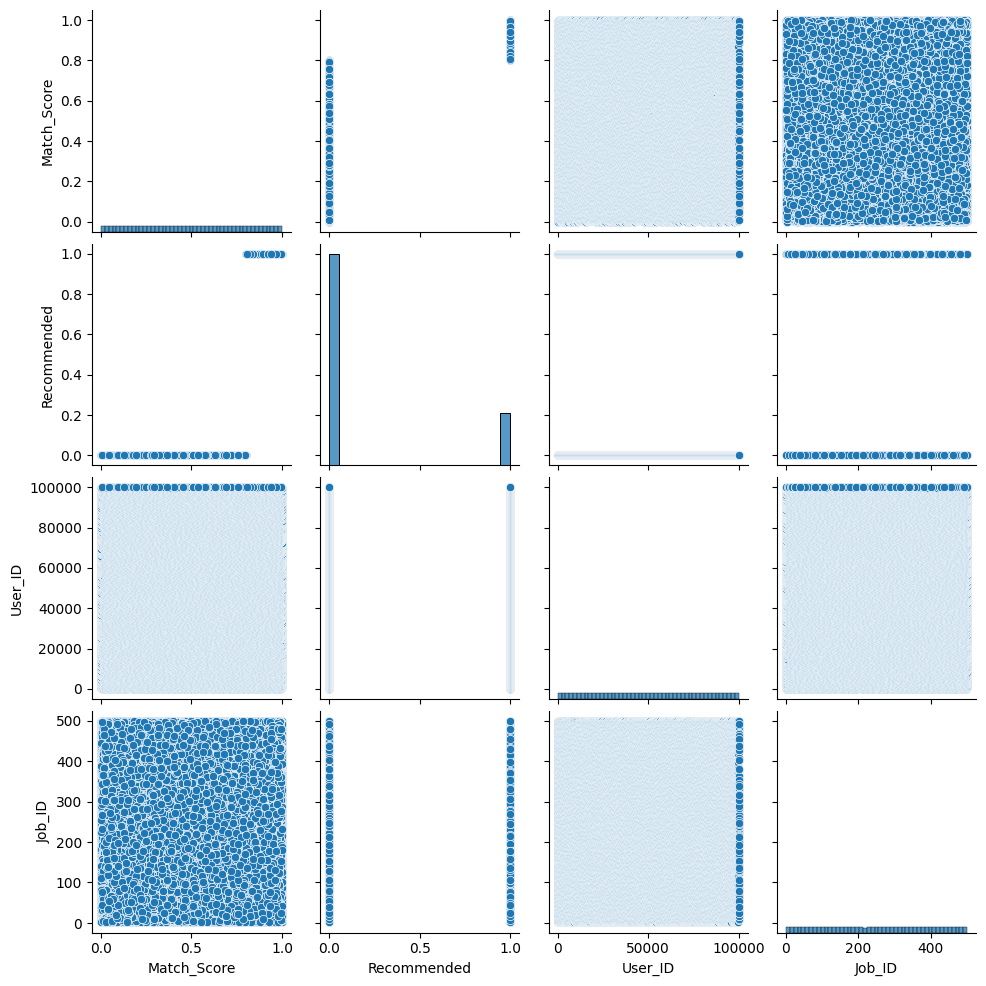

In [14]:
sns.pairplot(df[numeric_cols])
plt.show()

Penjelasan Scatter Plot antar Variabel adalah sebagai berikut:
1. Match_Score vs Recommended:
- Terlihat pola positif: sebagian besar data dengan Match_Score tinggi dikaitkan dengan Recommended = 1.
- Ini memperkuat korelasi positif kuat (r = 0.69) antara keduanya.
2. Match_Score vs User_ID / Job_ID:
- Tidak tampak pola yang jelas → menandakan tidak ada korelasi (juga didukung oleh heatmap sebelumnya).
3. Recommended vs User_ID / Job_ID:
- Titik-titik tersebar tanpa pola → mengindikasikan tidak ada hubungan berarti.
4. User_ID vs Job_ID:
- Scatter plot tampak seperti grid, karena kedua variabel bersifat ID dan diskrit → tidak relevan secara prediktif.

Top 10 nilai yang sering muncul di kolom 'User_Skills':
-  Machine Learning: 25174
-  SQL: 25158
-  Data Science: 25108
-  AI: 25091
-  CSS: 25047
-  Java: 25040
-  C++: 25031
-  JavaScript: 24956
-  HTML: 24899
-  Python: 24834


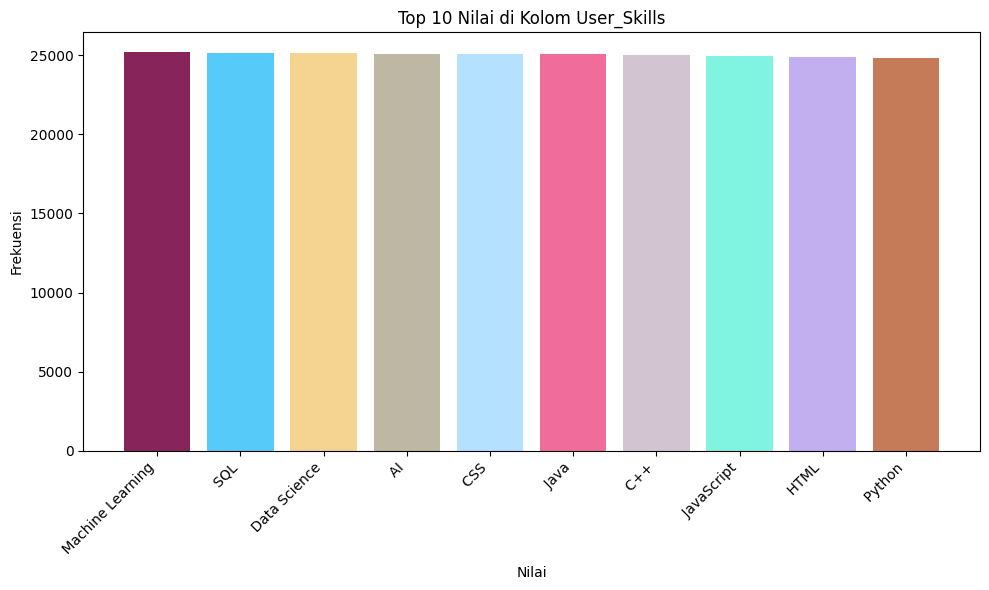

Top 10 nilai yang sering muncul di kolom 'Job_Requirements':
-  CSS: 25120
-  Machine Learning: 25109
-  Java: 25104
-  AI: 25071
-  JavaScript: 25056
-  HTML: 25048
-  C++: 25015
-  Data Science: 24916
-  SQL: 24901
-  Python: 24839


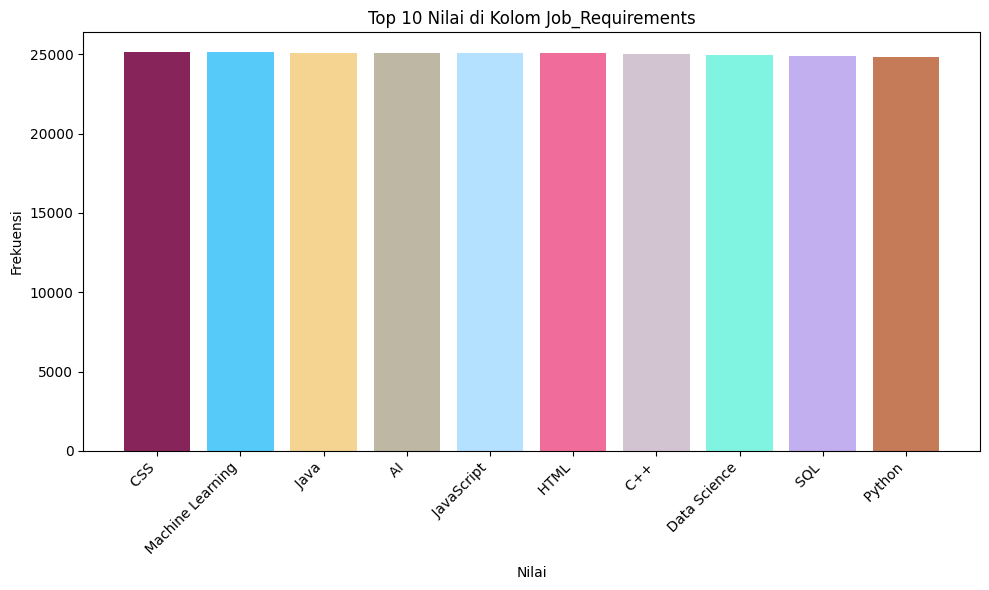

In [15]:
def plot_top_values(df, column_name, top_n=10):
    """
    Menampilkan dan memplot nilai-nilai teratas (top_n) yang paling sering muncul
    dalam kolom object DataFrame.

    Args:
        df: pandas DataFrame.
        column_name: Nama kolom (object type).
        top_n: Jumlah nilai teratas yang akan ditampilkan (default: 10).
    """
    all_values = []
    for values in df[column_name]:
        all_values.extend(values.split(','))

    value_counts = Counter(all_values)
    top_values = value_counts.most_common(top_n)

    print(f"Top {top_n} nilai yang sering muncul di kolom '{column_name}':")
    for value, count in top_values:
        print(f"- {value}: {count}")

    colors = ['#87255B', '#56CBF9', '#F5D491', '#BEB7A4', '#B4E1FF', '#F06C9B', '#D3C4D1', '#81F4E1', '#C2AFF0', '#C57B57']

    plt.figure(figsize=(10, 6))
    plt.bar([value[0] for value in top_values], [value[1] for value in top_values], color=colors)
    plt.title(f'Top {top_n} Nilai di Kolom {column_name}')
    plt.xlabel('Nilai')
    plt.ylabel('Frekuensi')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

plot_top_values(df, 'User_Skills')
plot_top_values(df, 'Job_Requirements')

1. Insight Top 10 Skill:
- Semua skill yang muncul tergolong dalam kategori teknikal dan programming, mengindikasikan dataset ini fokus pada pekerjaan di bidang IT, Data, dan Software Development.
- Perbedaan frekuensi antar skill sangat kecil → menunjukkan distribusi keterampilan yang hampir merata di antara pengguna.
- Machine Learning, SQL, dan Data Science berada di puncak, mengindikasikan tren besar ke arah bidang data-centric seperti AI, Data Analysis, dan Machine Learning Engineering.
- Bahasa pemrograman populer seperti Python, Java, C++, dan web tech seperti HTML, CSS, JavaScript juga banyak dikuasai.

2. Insight Top 10 Job_Requirements:
- Skill yang dicari oleh pekerjaan hampir identik dengan skill yang paling banyak dimiliki oleh user (lihat grafik sebelumnya), yang mengindikasikan:
- Kesesuaian tinggi antara supply dan demand skill.
- Peluang besar untuk membangun sistem rekomendasi yang efektif berdasarkan kesamaan skill.
- CSS dan JavaScript muncul sangat tinggi di sini — ini menunjukkan permintaan besar untuk front-end atau full-stack developers.
- Skill AI dan Machine Learning juga sangat tinggi, mengkonfirmasi tren industri teknologi yang kuat ke arah otomatisasi dan kecerdasan buatan.

# Data Preparation

Penanganan Outliers

In [16]:
filter = ~((df.select_dtypes(include=np.number) < (Q1 - 1.5 * IQR)) | (df.select_dtypes(include=np.number) > (Q3 + 1.5 * IQR))).any(axis=1)

df = df[filter]

df.shape

(80073, 6)

Dataset setelah mengatasi outliers

In [17]:
for i, (nama_kolom, jumlah) in enumerate(df.count().items(), 1):
  print(f'Kolom {i}: {nama_kolom} - Berjumlah: {jumlah}')

Kolom 1: User_ID - Berjumlah: 80073
Kolom 2: Job_ID - Berjumlah: 80073
Kolom 3: User_Skills - Berjumlah: 80073
Kolom 4: Job_Requirements - Berjumlah: 80073
Kolom 5: Match_Score - Berjumlah: 80073
Kolom 6: Recommended - Berjumlah: 80073


In [18]:
df

,User_ID,Job_ID,User_Skills,Job_Requirements,Match_Score,Recommended
0,1,16,"Python, C++, Machine Learning","SQL, CSS, AI, JavaScript, Data Science",0.620421,0
2,3,319,"CSS, Python, Machine Learning","SQL, AI, Python",0.703830,0
3,4,399,"SQL, Machine Learning, C++","Java, AI, Python, Data Science, Machine Learning",0.224724,0
4,5,405,"Machine Learning, HTML, JavaScript","Machine Learning, C++",0.296453,0
5,6,66,"Java, Data Science","HTML, CSS, Python, Machine Learning",0.674309,0
...,...,...,...,...,...,...
99995,99996,380,"C++, Machine Learning, SQL","Machine Learning, C++, CSS, SQL, HTML",0.537153,0
99996,99997,402,"C++, SQL, HTML, Python, JavaScript","Data Science, AI, JavaScript",0.319933,0
99997,99998,212,"Data Science, C++","C++, Java",0.292062,0
99998,99999,40,"Python, HTML, AI","AI, CSS, Python, C++, JavaScript",0.450705,0


In [19]:
# Mengonversi keterampilan menjadi set
df['User_Skills_Set'] = df['User_Skills'].apply(lambda x: set(x.split(', ')))
df['Job_Requirements_Set'] = df['Job_Requirements'].apply(lambda x: set(x.split(', ')))


C:\Users\Sinta\AppData\Local\Temp\ipykernel_20768\3901369721.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['User_Skills_Set'] = df['User_Skills'].apply(lambda x: set(x.split(', ')))
C:\Users\Sinta\AppData\Local\Temp\ipykernel_20768\3901369721.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Job_Requirements_Set'] = df['Job_Requirements'].apply(lambda x: set(x.split(', ')))


#### TF-IDF

In [78]:
# TF-IDF vectorizer
vectorizer = TfidfVectorizer(max_features=100, max_df=0.8)
vectorizer.fit(df['Job_Requirements'])

user_vecs = vectorizer.transform(df['User_Skills'])
job_vecs = vectorizer.transform(df['Job_Requirements'])

`user_vecs` dan `job_vecs` adalah representasi vektor numerik dari skill user dan kebutuhan job, siap digunakan untuk menghitung rekomendasi score

In [22]:
user_vecs[0]

<1x11 sparse matrix of type '<class 'numpy.float64'>'
	with 3 stored elements in Compressed Sparse Row format>

#### Preprocessing Collaborative Filtering

In [ ]:
# Buat instance LightFM Dataset
dataset = Dataset()

# Fit user dan job IDs
dataset.fit(df['User_ID'], df['Job_ID'])

# Buat (user_id, job_id, interaction) tuples
interactions = list(zip(df['User_ID'], df['Job_ID']))
interactions_labels = df['Recommended'].astype(float)

# Build interaction matrix
(interaction_matrix, _) = dataset.build_interactions(zip(df['User_ID'], df['Job_ID'], interactions_labels))

Mempersiapkan data interaksi (user-job) dalam format LightFM, sebuah library rekomendasi berbasis model hybrid (content + collaborative filtering). Dimana output yang dihasilkan adalah `interaction_matrix`: Matrix besar yang menyimpan interaksi eksplisit (`Recommended`) antara user dan job, siap digunakan untuk training model rekomendasi.

### Splitting Data

In [ ]:
train_interactions, test_interactions = random_train_test_split(interaction_matrix, test_percentage=0.2)

In [82]:
user_train, user_test, job_train, job_test = train_test_split(user_vecs, job_vecs, test_size=0.2, random_state=42)

job_test = [row.indices.tolist() for row in job_test]
relevant_job_ids = sorted(set(j for jobs in job_test for j in jobs))

filtered_job_vecs = job_vecs[relevant_job_ids]
index_map = {new: old for new, old in enumerate(relevant_job_ids)}


Membagi dataset menjadi 80% data training dan 20 data testing

# Model Development

## Model Collaborative Filtering (User_Skills dan Job Requirements)

### Model NearestNeighbors

**NearestNeighbors** dari sklearn adalah metode memory-based collaborative filtering. Ia mencari item terdekat (neighbors) menggunakan metrik kesamaan (misalnya cosine similarity).

In [83]:
nn = NearestNeighbors(n_neighbors=10, metric='cosine')
nn.fit(normalize(filtered_job_vecs))

# Cari rekomendasi
distances, new_indices = nn.kneighbors(normalize(user_test))

parameter yang dilibatkan adalah sebagai berikut:
- `n_neighbors` = untuk setiap titik data yang akan dicari tetangganya, algoritma akan mengembalikan 5 titik terdekat
- `metric` = `cosine` = menggunakan metric cosine similarity

In [84]:
indices = [[index_map[i] for i in user_recs] for user_recs in new_indices]

In [87]:
recommendations = []
for user_idx, job_indices in enumerate(indices):
    # Akses User_ID berdasarkan posisi baris
    user_id = df.iloc[user_idx]['User_ID']
    
    for rank, job_idx in enumerate(job_indices):
        # Pastikan job_idx masih dalam jangkauan
        try:
            job_id = df.iloc[job_idx]['Job_ID']
        except IndexError:
            print(f"IndexError: job_idx {job_idx} out of range (len={len(df)})")
            continue

        # Ambil distance spesifik untuk pasangan (user_idx, rank),
        # lalu ubah ke similarity dengan 1 - distance
        score = 1 - distances[user_idx][rank]

        recommendations.append({
            'User_ID': user_id,
            'Job_ID': job_id,
            'Similarity_Score': round(score, 4)
        })

recommend_df = pd.DataFrame(recommendations)
print(recommend_df.head(5))

   User_ID  Job_ID  Similarity_Score
0        1     405            1.0000
1        1      68            0.8156
2        1     413            0.7064
3        1      66            0.6322
4        1     440            0.5771


Melihat Similarity pada setiap user setiap user dimana diberikan 5 rekomendasi untuk setiap user

In [88]:
# Misalnya melihat rekomendasi untuk user dengan ID 9
target_user_id = 9

user_recommendations = recommend_df[recommend_df['User_ID'] == target_user_id]

print(user_recommendations)

    User_ID  Job_ID  Similarity_Score
60        9     399            0.7715
61        9      16            0.6667
62        9     413            0.6117
63        9     405            0.5770
64        9     440            0.4997
65        9      68            0.4706
66        9      66            0.3648
67        9     247            0.2883
68        9     319            0.2353
69        9      53            0.1820


Sistem telah berhasil merekomendasikan top 5 pekerjaan yang mirip dengan kebutuhan user disesuaikan dengan beberapa skills yang dimiliki oleh user tersebut.

## Model Collaborative Filtering + Content Based Filtering (Hybrid)

**LightFM** adalah library Python yang menggabungkan collaborative filtering dan content-based filtering melalui model pembelajaran representasi (embedding). LightFM menggunakan pembelajaran matrix factorization dengan pendekatan supervised (menggunakan loss function seperti BPR, logistic, hinge, atau WARP)

In [36]:
model = LightFM(loss='warp')
model.fit(train_interactions, epochs=20, num_threads=2)

Parameter yang digunakan adalah `loss` = `warp` untuk menentukan fungsi loss (fungsi kerugian) yang akan digunakan selama proses pelatihan model. Parameter ini penting karena menentukan cara model belajar dari data interaksi pengguna-item.

In [37]:
n_users, n_items = interaction_matrix.shape

user_id = 2000
scores = model.predict(user_id, np.arange(n_items))
top_jobs = np.argsort(-scores)[:5]

job_id_map, job_id_rev_map, _ = dataset.mapping()[1], {v: k for k, v in dataset.mapping()[1].items()}, _
top_job_ids = [job_id_rev_map[i] for i in top_jobs]

print(f"Top 5 rekomendasi pekerjaan untuk User {user_id}:\n")

for job_id in top_job_ids:
    if df[df['Job_ID'] == job_id].empty:
        print(f"Job_ID {job_id} not found in the original DataFrame.")
        continue

    job_info = df[df['Job_ID'] == job_id].iloc[0]
    job_info
    print(f"- Job_ID: {job_info['Job_ID']}")
    print(f"  Requirements: {job_info['Job_Requirements']}")
    print(f"  User Skills: {job_info['User_Skills']}\n")

Top 5 rekomendasi pekerjaan untuk User 2000:

- Job_ID: 499
  Requirements: CSS, HTML, SQL, Java
  User Skills: HTML, JavaScript, Java

- Job_ID: 137
  Requirements: Data Science, Machine Learning, JavaScript
  User Skills: CSS, Machine Learning, C++

- Job_ID: 45
  Requirements: AI, JavaScript, Java, Python, Machine Learning
  User Skills: Machine Learning, C++, AI, Python

- Job_ID: 176
  Requirements: JavaScript, HTML, C++, Data Science
  User Skills: C++, CSS, HTML, Machine Learning

- Job_ID: 255
  Requirements: HTML, Java, Python
  User Skills: Data Science, C++



Sistem telah menampilkan 5 rekomendasi pekerjaan untuk user yang dimasukkan, dengan beberapa keterangan lainnya yaitu `Job_Requirements` dan `User_Skills`

# Evaluation

### Evaluasi Collaborative Filtering

**Precision@K**

**Precision@K** mengukur seberapa banyak rekomendasi yang relevan di dalam **K rekomendasi teratas** yang diberikan oleh model. Precision menghitung **proporsi item relevan** dalam K item yang diprediksi oleh model.

**Rumus Precision@K:**

$
\text{Precision@K} = \frac{\text{Jumlah item relevan di top-K}}{K}
$

Dimana:
- **Jumlah item relevan di top-K** adalah jumlah item yang relevan dalam K rekomendasi teratas.
- **K** adalah jumlah item teratas yang direkomendasikan.

In [69]:
def precision_at_k(indices, true_jobs, k=10):
    total_precision = 0
    for i, recs in enumerate(indices):
        relevant = set(true_jobs[i])
        recommended = set(recs[:k])
        precision = len(recommended & relevant) / k
        total_precision += precision
    return total_precision / len(indices)


**Recall@K**

**Recall@K** mengukur seberapa banyak item relevan yang ditemukan di dalam **K rekomendasi teratas** yang diberikan oleh model. Recall menghitung **proporsi item relevan** yang berhasil diprediksi oleh model dari seluruh item relevan yang ada.

**Rumus Recall@K:**

$
\text{Recall@K} = \frac{\text{Jumlah item relevan di top-K}}{\text{Jumlah total item relevan}}
$

Dimana:
- **Jumlah total item relevan** adalah jumlah keseluruhan item relevan yang seharusnya direkomendasikan kepada pengguna.
- **K** adalah jumlah item teratas yang direkomendasikan.

In [63]:
def recall_at_k(indices, true_jobs, k=10):
    total_recall = 0
    for i, recs in enumerate(indices):
        relevant = set(true_jobs[i])
        if len(relevant) == 0:
            continue
        recommended = set(recs[:k])
        recall = len(recommended & relevant) / len(relevant)
        total_recall += recall
    return total_recall / len(indices)

**MAP (Mean Average Precision)** adalah salah satu metrik evaluasi yang digunakan dalam sistem rekomendasi dan pencarian informasi untuk **mengukur kualitas peringkat hasil rekomendasi** berdasarkan relevansi terhadap ground truth (label kebenaran).

MAP menilai:
- Seberapa awal item yang relevan muncul dalam daftar rekomendasi.
- Seberapa lengkap item relevan tercakup dalam top-K rekomendasi.

Rumus MAP

MAP dihitung sebagai rata-rata dari **Average Precision (AP)** untuk setiap user.

1. Average Precision (AP)

Untuk satu user:

$
\text{AP} = \frac{1}{|\text{Item Relevan}|} \sum_{k=1}^{N} P(k) \cdot rel(k)
$

- \( P(k) \) = Precision pada posisi ke-`k`.
- \( rel(k) \) = 1 jika item ke-`k` relevan, 0 jika tidak.
- \( N \) = Jumlah item direkomendasikan.

2. Mean Average Precision (MAP)

$
\text{MAP} = \frac{1}{|U|} \sum_{u=1}^{|U|} \text{AP}_u
$

- \( |U| \) = Jumlah user.
- $\text{AP}_u$ = Average Precision untuk user ke-`u`.

In [64]:
def apk(actual, predicted, k=10):
    """
    Average Precision at k
    """
    if not actual:
        return 0.0
    score = 0.0
    num_hits = 0.0
    for i, p in enumerate(predicted[:k]):
        if p in actual and p not in predicted[:i]:  # Avoid duplicate
            num_hits += 1.0
            score += num_hits / (i + 1.0)
    return score / min(len(actual), k)

def map_at_k(indices, true_jobs, k=10):
    return np.mean([apk(true_jobs[i], indices[i], k) for i in range(len(indices))])

In [89]:
p_at_10 = precision_at_k(indices, job_test, k=10)
r_at_10 = recall_at_k(indices, job_test, k=10)
map10 = map_at_k(indices, job_test, k=10)

print(f"Precision@10: {p_at_10:.4f}")
print(f"Recall@10:    {r_at_10:.4f}")
print(f"MAP@10:       {map10:.4f}")


Precision@10: 0.3520
Recall@10:    0.9099
MAP@10:       0.4529


* **Precision@10**: 0.3520
    Makna: Dari 10 rekomendasi teratas yang diberikan oleh sistem, sekitar 35.2% benar-benar relevan.
  * **Interpretasi**: Model masih menghasilkan cukup banyak item yang relevan di posisi atas. Untuk sistem rekomendasi, ini berarti hanya 3 dari 10 item yang direkomendasikan tepat sasaran

* **Recall@10**: 0.9099
    Makna: Dari semua item relevan yang seharusnya direkomendasikan, 90.9% berhasil dimasukkan dalam 10 besar.
    * **Interpretasi**: Model sangat baik dalam menemukan item yang relevan — ia menangkap sebagian besar dari apa yang penting, meskipun tidak semuanya benar-benar akurat jika melihat nilai precision.

* **MAP@10**: 0.4529
    Makna: Kualitas ranking cukup baik, 42.2% berhasil dimasukkan dalam 10 besar.
    * **Interpretasi**: Model cukup baik dalam menemukan item yang relevan — Kualitas ranking yang didapatkan mampu memberikan item relevan relatif muncul di daftar awal

### b. Evaluasi Hybrid Recommendation

**ROC-AUC** adalah metrik evaluasi untuk masalah klasifikasi biner yang mengukur kemampuan model dalam membedakan antara dua kelas (dalam kasusmu: pekerjaan yang direkomendasikan 1 dan tidak 0).

ROC adalah kurva yang menunjukkan trade-off antara:
- True Positive Rate (TPR): berapa banyak item positif yang berhasil dikenali (juga disebut Recall)
- False Positive Rate (FPR): berapa banyak item negatif yang salah diklasifikasi sebagai positif

AUC (Area Under Curve) adalah luas di bawah kurva ROC, dengan nilai antara:
- 1.0 = model sempurna
- 0.5 = model tebak-tebakan (random guess)
- < 0.5 = model buruk (prediksi berlawanan)

In [38]:
# Precision at k
precision = precision_at_k(model, interaction_matrix, k=5).mean()
print(f"Precision@5: {precision:.4f}")

recall = recall_at_k(model, interaction_matrix, k=5).mean()
print(f"Recall@5: {recall:.4f}")

# ROC AUC Score
auc = auc_score(model, interaction_matrix).mean()
print(f"AUC Score: {auc:.4f}")

Precision@5: 0.1604
Recall@5: 0.8020
AUC Score: 0.9004


* **Precision@5**: 0.1604
    Makna: Dari 5 rekomendasi teratas yang diberikan oleh sistem, sekitar 16.04% benar-benar relevan.
  * **Interpretasi**: Model masih menghasilkan cukup banyak item yang tidak relevan di posisi atas. Untuk sistem rekomendasi, ini berarti hanya 1 dari 6 item yang direkomendasikan tepat sasaran

  * **Recall@5**: 0.8020
    Makna: Dari semua item relevan yang seharusnya direkomendasikan, 80.20% berhasil dimasukkan dalam 5 besar.
    * **Interpretasi**: Model sangat baik dalam menemukan item yang relevan — ia menangkap sebagian besar dari apa yang penting, meskipun tidak semuanya benar-benar akurat (lihat Precision).

  * **AUC Score**: 0.9004
     Makna: Ini adalah Area Under the ROC Curve, yang mengukur kemampuan model membedakan antara kelas (relevan vs tidak relevan).
    * **Interpretasi**: Skor 0.9004 sangat bagus — model secara keseluruhan mampu membedakan antara item relevan dan tidak relevan dengan tingkat keakuratan tinggi.